# Flooding likelihood
TODO: to find out what is the expected probability of flooding given rainfall intensities (total daily rainfall, maximum 30 min, maximum 60 min, maximum 120 min)

In [1]:
import pandas as pd
import numpy as np
import importlib
import os
import matplotlib.pyplot as plt
import pymc as pm
import pytensor.tensor as at
import arviz as az
from scipy.stats.mstats import mquantiles
import pickle
# importlib.reload(flood_utils)
# from flood_utils import get_weather_stns

# Import historical weather and flood data

In [2]:
imported_data_dir = os.path.join(os.getcwd(),"Exported_Data")
weather_df = pd.read_csv(os.path.join(imported_data_dir,"historical_weather.csv"))
# filter weather daya from 2014 to 2023
weather_df = weather_df[(weather_df['year'] > 2013) & (weather_df['year']< 2024)]
weather_df

,station,year,month,day,daily rainfall total (mm),highest 30 min rainfall (mm),highest 60 min rainfall (mm),highest 120 min rainfall (mm),mean temperature (degC),maximum temperature (degC),minimum temperature (degC),mean wind speed (km/h),max wind speed (km/h),Date,drainage_catchment
7305,Paya Lebar,2014.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,29.5,24.8,15.8,35.3,2014-01-01,Punggol
7306,Paya Lebar,2014.0,1.0,2.0,0.0,NaN,NaN,NaN,NaN,31.7,25.0,16.5,37.1,2014-01-02,Punggol
7307,Paya Lebar,2014.0,1.0,3.0,2.2,NaN,NaN,NaN,NaN,31.1,25.1,14.9,33.5,2014-01-03,Punggol
7308,Paya Lebar,2014.0,1.0,4.0,0.6,NaN,NaN,NaN,NaN,32.3,23.7,8.9,35.3,2014-01-04,Punggol
7309,Paya Lebar,2014.0,1.0,5.0,10.5,NaN,NaN,NaN,NaN,27.0,23.8,11.9,33.5,2014-01-05,Punggol
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457384,Pasir Ris (Central),2023.0,12.0,27.0,20.2,7.8,8.0,8.6,NaN,NaN,NaN,NaN,NaN,2023-12-27,Punggol
457385,Pasir Ris (Central),2023.0,12.0,28.0,29.6,15.4,25.0,26.8,NaN,NaN,NaN,NaN,NaN,2023-12-28,Punggol
457386,Pasir Ris (Central),2023.0,12.0,29.0,8.2,3.2,4.4,5.6,NaN,NaN,NaN,NaN,NaN,2023-12-29,Punggol
457387,Pasir Ris (Central),2023.0,12.0,30.0,0.6,0.6,0.6,0.6,NaN,NaN,NaN,NaN,NaN,2023-12-30,Punggol


In [3]:
flood_df = pd.read_csv(os.path.join(imported_data_dir,"precipitation_levels_during_flood_events.csv"))
flood_df

,flooded_location,responses_found,matched_location,latitude,longitude,closest_weather_stn,mean_pr,daily rainfall total (mm),highest 30 min rainfall (mm),highest 60 min rainfall (mm),highest 120 min rainfall (mm),drainage_catchment,time
0,Yishun MRT,9,DBS YISHUN MRT STATION,1.429525,103.834995,Yishun,17.395082,45.0,40.8,44.0,44.2,Woodlands,2014-03-20
1,2 KAKI BUKIT ROAD 3,1,2 KAKI BUKIT ROAD 3 SINGAPORE 417817,1.337334,103.901943,Tai Seng,7.993548,25.0,21.0,25.0,25.0,Geylang,2014-04-04
2,PSC Building,1,PSC BUILDING,1.328863,103.706189,Boon Lay (West),14.574603,89.5,49.5,83.0,89.0,Jurong,2014-04-23
3,21229 (bus stop),1,21229 (BUS STOP),1.342064,103.716020,Jurong (North),14.574603,65.4,51.6,63.8,65.4,Jurong,2014-04-23
4,Tengah Flyover,1,TENGAH FLYOVER,1.363822,103.707043,Jurong (North),22.195238,92.6,50.2,78.4,92.2,Kranji,2014-05-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,Buangkok Flyover,1,BUANGKOK FLYOVER,1.376840,103.910119,Paya Lebar,52.506522,76.2,45.4,68.6,70.4,Punggol,2022-12-11
207,Kramat Lane,1,KRAMAT LANE,1.300979,103.842274,Dhoby Ghaut,40.154348,71.4,35.6,63.2,70.2,Stamford Marina,2023-03-30
208,Cavenagh Road,1,CAVENAGH ROAD,1.308095,103.842140,Newton,40.154348,67.6,47.4,65.0,66.6,Bukit Timah,2023-03-30
209,42059 (Bus stop),1,42059 (BUS STOP),1.336445,103.782762,Clementi,67.604762,79.8,44.2,50.6,55.2,Pandan,2023-07-20


### Flooding likelihood per drainage catchment
Divide floods into their respective drainage catchments and date

In [4]:
flood_drainage_catchment = {x:y for x, y in flood_df.groupby('drainage_catchment',as_index=False)}
print(list(flood_drainage_catchment))
flood_drainage_catchment['Bukit Timah']

['Bukit Timah', 'Changi', 'Geylang', 'Jurong', 'Kallang', 'Kranji', 'Pandan', 'Punggol', 'Singapore River', 'Stamford Marina', 'Woodlands']


,flooded_location,responses_found,matched_location,latitude,longitude,closest_weather_stn,mean_pr,daily rainfall total (mm),highest 30 min rainfall (mm),highest 60 min rainfall (mm),highest 120 min rainfall (mm),drainage_catchment,time
11,Mackenzie Road,1,MACKENZIE ROAD,1.305873,103.848002,Dhoby Ghaut,33.603333,95.8,49.4,84.8,95.6,Bukit Timah,2014-07-29
13,Bassein Road,1,BASSEIN ROAD,1.323316,103.848088,Whampoa,33.603333,52.2,22.2,43.4,50.6,Bukit Timah,2014-07-29
21,40099 (bus stop),1,40099 (BUS STOP),1.321852,103.823440,Bukit Timah,44.081356,80.0,40.0,59.2,60.4,Bukit Timah,2014-11-08
51,Pek Kio CC,1,PEK KIO COMMUNITY CENTRE,1.313059,103.851374,Whampoa,29.008333,63.4,48.8,63.0,63.4,Bukit Timah,2015-12-11
52,Balestier Point,2,BALESTIER POINT,1.322812,103.852026,Whampoa,29.008333,63.4,48.8,63.0,63.4,Bukit Timah,2015-12-11
53,50199 (Bus Stop),1,50199 (BUS STOP),1.324968,103.850509,Whampoa,29.008333,63.4,48.8,63.0,63.4,Bukit Timah,2015-12-11
70,Newton Circus,2,NEWTON CIRCUS,1.313224,103.838945,Newton,34.901754,62.4,44.8,56.6,60.0,Bukit Timah,2016-12-24
71,Balmoral Road,1,BALMORAL ROAD,1.313244,103.830181,Newton,34.901754,62.4,44.8,56.6,60.0,Bukit Timah,2016-12-24
72,Cairnhill Road,2,CAIRNHILL ROAD,1.308031,103.836841,Newton,34.901754,62.4,44.8,56.6,60.0,Bukit Timah,2016-12-24
73,Stevens Road,1,STEVENS ROAD,1.313170,103.828976,Newton,34.901754,62.4,44.8,56.6,60.0,Bukit Timah,2016-12-24


### Split weather dataframe into their drainage catchments

In [5]:
weather_drainage_catchment = {x:y for x, y in weather_df.groupby('drainage_catchment',as_index=False)}
list(weather_drainage_catchment)
weather_drainage_catchment['Bukit Timah']

,station,year,month,day,daily rainfall total (mm),highest 30 min rainfall (mm),highest 60 min rainfall (mm),highest 120 min rainfall (mm),mean temperature (degC),maximum temperature (degC),minimum temperature (degC),mean wind speed (km/h),max wind speed (km/h),Date,drainage_catchment
18506,Macritchie Reservoir,2014.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2014-01-01,Bukit Timah
18507,Macritchie Reservoir,2014.0,1.0,2.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2014-01-02,Bukit Timah
18508,Macritchie Reservoir,2014.0,1.0,3.0,1.4,1.0,1.4,1.4,NaN,NaN,NaN,NaN,NaN,2014-01-03,Bukit Timah
18509,Macritchie Reservoir,2014.0,1.0,4.0,11.4,7.0,7.8,7.8,NaN,NaN,NaN,NaN,NaN,2014-01-04,Bukit Timah
18510,Macritchie Reservoir,2014.0,1.0,5.0,6.6,1.6,2.8,4.6,NaN,NaN,NaN,NaN,NaN,2014-01-05,Bukit Timah
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442193,Bukit Timah,2023.0,12.0,27.0,6.6,1.4,2.0,3.0,NaN,NaN,NaN,NaN,NaN,2023-12-27,Bukit Timah
442194,Bukit Timah,2023.0,12.0,28.0,31.2,16.4,17.8,21.8,NaN,NaN,NaN,NaN,NaN,2023-12-28,Bukit Timah
442195,Bukit Timah,2023.0,12.0,29.0,2.8,2.0,3.2,4.4,NaN,NaN,NaN,NaN,NaN,2023-12-29,Bukit Timah
442196,Bukit Timah,2023.0,12.0,30.0,1.6,1.4,1.4,1.4,NaN,NaN,NaN,NaN,NaN,2023-12-30,Bukit Timah


# Prepare data sets
- Outputs per drainage catchment:
    - binary flood occurrences (nx1)
    - precipitation ranges that lead to flood (nx4): where 1st column = total ppt, 2nd column = max 30, 3rd column = max 60, 4th column = max 120

In [6]:
def get_non_flood_dates(weather_dates, flood_dates):
    """ returns a list of non_flood dates
    Args:
        weather_dates (list of str): list of all weather dates
        flood_dates (list of str): list of all flood dates
    Returns:
        list: a list of flood dates (str)
    """
    unique_weather_dates = set(weather_dates)
    unique_flood_dates = set(flood_dates)
    return sorted(unique_weather_dates^unique_flood_dates)

def subset_nonflood_weather(weather_df,non_flood_dates):
    """ returns a pd.DataFrame which shows non flood weather
    Args:
        weather_df (pd.DataFrame): weather df with the column Date
        non_flood_dates (list): list of str of non_flood_dates
    Returns:
        pd.DataFrame: non-flood weather, averaged across weather stations
    """
    return weather_df[weather_df['Date'].isin(non_flood_dates)].groupby('Date').mean(numeric_only=True).reset_index()


non_flood_dates = get_non_flood_dates(weather_drainage_catchment['Bukit Timah']['Date'].to_list(), 
                    flood_drainage_catchment['Bukit Timah']['time'].to_list())
subset_nonflood_weather(weather_drainage_catchment['Bukit Timah'],non_flood_dates)

,Date,year,month,day,daily rainfall total (mm),highest 30 min rainfall (mm),highest 60 min rainfall (mm),highest 120 min rainfall (mm),mean temperature (degC),maximum temperature (degC),minimum temperature (degC),mean wind speed (km/h),max wind speed (km/h)
0,2014-01-01,2014.0,1.0,1.0,0.00,0.00,0.00,0.00,26.4,29.0,24.4,7.4,40.3
1,2014-01-02,2014.0,1.0,2.0,0.00,0.00,0.00,0.00,27.1,30.6,25.0,7.1,35.6
2,2014-01-03,2014.0,1.0,3.0,0.72,0.48,0.60,0.64,26.7,30.5,25.1,6.7,37.8
3,2014-01-04,2014.0,1.0,4.0,17.08,13.96,15.96,16.04,26.5,31.9,24.2,4.8,34.9
4,2014-01-05,2014.0,1.0,5.0,6.44,1.72,2.68,4.32,24.7,25.9,23.5,5.9,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3628,2023-12-27,2023.0,12.0,27.0,9.70,3.05,3.60,4.45,25.6,29.0,24.2,5.7,28.9
3629,2023-12-28,2023.0,12.0,28.0,33.15,15.15,16.95,20.85,26.0,30.8,24.1,5.1,39.3
3630,2023-12-29,2023.0,12.0,29.0,4.95,3.70,4.35,5.20,27.2,31.0,25.0,5.7,29.4
3631,2023-12-30,2023.0,12.0,30.0,1.80,1.20,1.30,1.50,27.2,29.8,25.8,5.6,33.9


### Get non flood data

In [7]:
non_flood_data = dict()
for drainage_name in list(weather_drainage_catchment):
    non_flood_dates = get_non_flood_dates(weather_drainage_catchment[drainage_name]['Date'].to_list(), 
                        list(flood_drainage_catchment[drainage_name]))
    df = subset_nonflood_weather(weather_drainage_catchment[drainage_name],non_flood_dates)
    non_flood_data[drainage_name] = df[['daily rainfall total (mm)', 'highest 30 min rainfall (mm)','highest 60 min rainfall (mm)','highest 120 min rainfall (mm)']]
non_flood_data

{'Bukit Timah':       daily rainfall total (mm)  highest 30 min rainfall (mm)  \
 0                          0.00                          0.00   
 1                          0.00                          0.00   
 2                          0.72                          0.48   
 3                         17.08                         13.96   
 4                          6.44                          1.72   
 ...                         ...                           ...   
 3647                       9.70                          3.05   
 3648                      33.15                         15.15   
 3649                       4.95                          3.70   
 3650                       1.80                          1.20   
 3651                       7.25                          2.65   
 
       highest 60 min rainfall (mm)  highest 120 min rainfall (mm)  
 0                             0.00                           0.00  
 1                             0.00                  

### Get flood data

In [8]:
flood_data = dict()
for drainage_name,df in flood_drainage_catchment.items():
    flood_data[drainage_name] = df[['daily rainfall total (mm)', 'highest 30 min rainfall (mm)','highest 60 min rainfall (mm)','highest 120 min rainfall (mm)']]
flood_data

{'Bukit Timah':      daily rainfall total (mm)  highest 30 min rainfall (mm)  \
 11                        95.8                          49.4   
 13                        52.2                          22.2   
 21                        80.0                          40.0   
 51                        63.4                          48.8   
 52                        63.4                          48.8   
 53                        63.4                          48.8   
 70                        62.4                          44.8   
 71                        62.4                          44.8   
 72                        62.4                          44.8   
 73                        62.4                          44.8   
 84                        44.2                          35.2   
 87                        76.8                          51.2   
 90                        72.8                          51.0   
 102                       80.4                          34.6   
 103      

In [9]:
x = non_flood_data['Bukit Timah']['daily rainfall total (mm)'].values
print(x.shape)
print(sum(np.isnan(x)))
x = x[~np.isnan(x)]
print(x.shape)
np.hstack([x,x]).shape

(3652,)
0
(3652,)


(7304,)

### Combine non flood and flood data, and create binary vector for flood occurrence

In [10]:
def get_binary_flood_occurrence(flood_data, non_flood_data):
    """ returns paired data (tuple) with NAs removed. (binary flood occurrence, corresponding rainfall)
    Args:
        flood_data (dict): where keys = name of drainage catchment, values = df (nx4) of rainfall corresponding to flood events
        non_flood_data (dict): where keys = name of drainage catchment, values = df (nx4) of rainfall corresponding to non flood events
    Returns:
        dict: keys = name of drainage catchment, 2nd-level keys = rainfall type, values = tuple of (binary flood occurrence, corresponding rainfall)
    """
    assert len(list(flood_data)) == len(list(non_flood_data)), f"Number of drainage catchment names do not match: {list(flood_data)}, {list(non_flood_data)}"

    flood_occurrences_dict = {drainage_name: {rf: None for rf in df.columns.to_list()} for drainage_name,df in flood_data.items()}
    for drainage_name, rf_dict in flood_occurrences_dict.items():
        for rainfall_type in list(rf_dict):
            # prepare flood data
            flood_ppt = flood_data[drainage_name][rainfall_type].values
            flood_ppt = flood_ppt[~np.isnan(flood_ppt)] # remove NAs
            flood_binary = np.ones(flood_ppt.shape,dtype=int) # where 1 = flood occurred
            # prepare non-flood data
            non_flood_ppt = non_flood_data[drainage_name][rainfall_type].values
            non_flood_ppt = non_flood_ppt[~np.isnan(non_flood_ppt)] # remove NAs
            non_flood_binary = np.zeros(non_flood_ppt.shape,dtype=int) # where 0 = flood did not occur
            # concat non-flood and flood data
            flood_occurrences_dict[drainage_name][rainfall_type] = (np.hstack([flood_binary,non_flood_binary]),np.hstack([flood_ppt, non_flood_ppt]))

    return flood_occurrences_dict

flood_occurrences_dict = get_binary_flood_occurrence(flood_data, non_flood_data)
flood_occurrences_dict  

{'Bukit Timah': {'daily rainfall total (mm)': (array([1, 1, 1, ..., 0, 0, 0]),
   array([95.8 , 52.2 , 80.  , ...,  4.95,  1.8 ,  7.25])),
  'highest 30 min rainfall (mm)': (array([1, 1, 1, ..., 0, 0, 0]),
   array([49.4 , 22.2 , 40.  , ...,  3.7 ,  1.2 ,  2.65])),
  'highest 60 min rainfall (mm)': (array([1, 1, 1, ..., 0, 0, 0]),
   array([84.8 , 43.4 , 59.2 , ...,  4.35,  1.3 ,  2.7 ])),
  'highest 120 min rainfall (mm)': (array([1, 1, 1, ..., 0, 0, 0]),
   array([95.6 , 50.6 , 60.4 , ...,  5.2 ,  1.5 ,  2.85]))},
 'Changi': {'daily rainfall total (mm)': (array([1, 1, 1, ..., 0, 0, 0]),
   array([40.4, 64.4, 22.4, ..., 10.8,  0.4, 23.2])),
  'highest 30 min rainfall (mm)': (array([1, 1, 1, ..., 0, 0, 0]),
   array([18.  , 55.2 , 12.2 , ...,  6.95,  0.4 ,  8.25])),
  'highest 60 min rainfall (mm)': (array([1, 1, 1, ..., 0, 0, 0]),
   array([26.  , 60.8 , 12.4 , ...,  9.3 ,  0.4 , 10.65])),
  'highest 120 min rainfall (mm)': (array([1, 1, 1, ..., 0, 0, 0]),
   array([39.2 , 61.2 , 22.2

True (3681,) 29


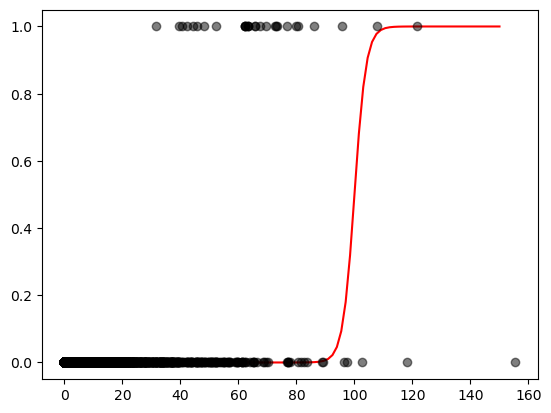

5

In [11]:
y,x = flood_occurrences_dict['Bukit Timah']['daily rainfall total (mm)']
print(y.shape == x.shape, x.shape,np.sum(y))

def logistic(x, beta, alpha):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

plt.figure()
X = np.linspace(0,150,100)
plt.plot(X,logistic(X,-0.5,50),'r-')
plt.plot(x,y,'ko',alpha=0.5)
plt.show()

np.sum(x>100)

In [ ]:
def logistic(x, beta, alpha):
    """ logistic curve
    """
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

def bayesian_flood_model(x,y,
                         beta_mu,beta_tau,beta_initval,
                         alpha_mu,alpha_tau,alpha_initval,
                         n_sampling=10000):
    """ returns bayesian model after initialising the priors and fitting a logistic curve
    Args:
        x (np.array): x-variable e.g. precipitation
        y (np.array): y-variable e.g. observations of flood in binary, where 1=flood, 0=non-flood
        beta_mu (float): mean value for prior that determines the steepness of the gradient
        beta_tau (float): precision for prior, the higher the precision, the smaller the standard dev
        beta_initval (float): initial value
        alpha_mu (float): mean value for prior that determines the x-shift of the logistic curve
        alpha_tau (float): precision for prior, the higher the precision, the smaller the standard dev
        alpha_initval (float): initial value
    Returns:
        trace: posterior distribution
    """
    with pm.Model() as model:
        beta = pm.Normal("beta", mu=beta_mu, tau=beta_tau, initval=beta_initval)
        alpha = pm.Normal("alpha", mu=alpha_mu, tau=alpha_tau, initval=alpha_initval)
        # fits a logistic curve where p(x) is the probability of flood given rainfall
        p = pm.Deterministic("p", 1.0/(1. + at.exp(beta*x + alpha)))

    with model:
        # fit a bernoulli distribution where Ber(p) is a random variable that takes 1 with a probability and 0 woth another probability 
        observed = pm.Bernoulli("bernoulli_obs", p, observed=y)
        start = pm.find_MAP() # maximum a posterior
        step = pm.Metropolis() #MCMC sampling
        trace = pm.sample(n_sampling, step=step, initvals=start) # MCMC sampling 
    return trace

def pickle_data(data,save_fp):
    """ serialize data into pickle
    Args:
        data: posterior distribution
        save_fp (str): save serialized object into fp
    """
    with open(f'{save_fp}.pkl','wb') as f:
        pickle.dump(data,f, protocol=pickle.HIGHEST_PROTOCOL)

def load_pickle(fp):
    with open(fp,'rb') as f:
        data = pickle.load(f)
    return data

def plot_posterior_arviz(trace,title,save_fp=None):
    """ plot distribution of parameters using trace
    Args:
        trace: posterior distribution
        title (str): title of figure
        save_fp (str): filepath of where to save the file
    """
    #Here is the ArviZ version 
    fig,ax = plt.subplots(2,1,figsize=(8,6))
    az.plot_posterior(trace, var_names=['beta'], kind='hist',bins=25,color="#7A68A6",ax=ax[0])
    az.plot_posterior(trace, var_names=['alpha'], kind='hist',bins=25,color="#A60628",ax=ax[1])
    plt.suptitle(f'{title}\n' + r"Posterior distributions of the variables $\alpha, \beta$",
                 fontsize=20)
    ax[0].set_title(r"posterior of $\beta$")
    ax[1].set_title(r"posterior of $\alpha$")
    plt.plot()
    plt.tight_layout()
    if save_fp is not None:
        plt.savefig(f'{save_fp}.png', bbox_inches = 'tight')
    plt.show()
    return

def plot_posterior(trace,title,save_fp=None):
    """ plot distribution of parameters using trace
    Args:
        trace: posterior distribution
        title (str): title of figure
        ax (Axes): if ax is None, plot on a new figure, else, draw on supplied ax
        save_fp (str): filepath of where to save the file
    """
    alpha_samples = np.concatenate(trace.posterior.alpha.data[:,1000::2])[:, None]  # best to make them 1d
    beta_samples = np.concatenate(trace.posterior.beta.data[:,1000::2])[:, None]

    #histogram of the samples:
    fig, axes = plt.subplots(2,1,figsize=(8,6))
    
    fig.suptitle(f'{title}\n' + r"Posterior distributions of the variables $\alpha, \beta$")
    axes[0].hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
            label=r"posterior of $\beta$", color="#7A68A6", density=True)
    axes[1].hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
            label=r"posterior of $\alpha$", color="#A60628", density=True)
    plt.tight_layout()
    for ax in axes.flatten():
        ax.legend(loc='upper right')
    if save_fp is not None:
        plt.savefig(f'{save_fp}.png', bbox_inches = 'tight')
    plt.show()
    return

def sample_posterior(x,trace):
    """ 
    Args:
        x (np.array): x-variable e.g. precipitation
        trace: posterior distribution from MCMC sampling
    Returns:
        np.arrays: posterior distributions of alpha, beta, and expected probabilities
    """
    # only take samples from the trace from 1000 onwards and sample every other
    alpha_samples = np.concatenate(trace.posterior.alpha.data[:,1000::2])[:, None]  # best to make them 1d
    beta_samples = np.concatenate(trace.posterior.beta.data[:,1000::2])[:, None]
    t = np.linspace(x.min(), x.max(), 50)[:, None]
    p_t = logistic(t.T, beta_samples, alpha_samples)
    return alpha_samples, beta_samples,p_t

def plot_fitted_logistic(x,y,sampled_posterior,title,ax=None,**kwargs):
    """ plot fitted logistic
    Args:
        x (np.array): x-variable e.g. precipitation
        y (np.array): y-variable e.g. observations of flood in binary, where 1=flood, 0=non-flood
        sampled_posterior: posterior distribution sampled from the trace from 1000 onwards and sample every other
        title (str): title of figure
        ax (Axes): if ax is None, plot on a new figure, else, draw on supplied ax
    Returns:
        np.array: returns expected probability
    """
    
    t = np.linspace(x.min(), x.max(), 50)[:, None]
    p_t = sampled_posterior
    # p_t = logistic(t.T, beta_samples, alpha_samples)
    mean_prob_t = p_t.mean(axis=0) # expected probability
    # vectorized bottom and top 2.5% quantiles for "confidence interval"
    qs = mquantiles(p_t, [0.025, 0.975], axis=0)
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,6))
    # plot expected probability
    ax.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="average posterior probability of flood")
    # plot uncertainty range
    ax.fill_between(t[:, 0], *qs, alpha=0.7,**kwargs)
    ax.plot(t[:, 0], qs[0], label="95% CI",alpha=0.7,**kwargs)
    # plot observations
    ax.scatter(x, y, color="k", s=50, alpha=0.5)
    ax.set_ylabel("probability estimate")
    ax.set_xlabel("Precipitation (mm)")
    ax.set_xlim(t.min(), t.max())
    ax.set_ylim(-0.02, 1.02)
    ax.set_title(title)
    if ax is None:
        plt.legend(loc="lower left")
        plt.show()
    return p_t

# Expected probability of flood per drainage catchment

In [26]:
for drainage_name, rf_dict in flood_occurrences_dict.items():
    for rf_type, rf in rf_dict.items():
        y,x = rf # flood occurrence vs ppt
        # use mean as the prior
        prior_mu = np.mean(x[y>0])
        print(f'{drainage_name} ({rf_type}),{prior_mu}')
        # fit bayesian model
        trace = bayesian_flood_model(x,y,
                                    beta_mu=0,beta_tau=0.5,beta_initval=0,
                                    alpha_mu=prior_mu,alpha_tau=0.5,alpha_initval=prior_mu,
                                    n_sampling=10000)
        alpha_samples, beta_samples,p_t = sample_posterior(x,trace)
        pickle_data(p_t,save_fp=os.path.join(os.getcwd(),"Exported_Data",f'ExpectedProb_{drainage_name} ({rf_type})'))
        pickle_data(alpha_samples,save_fp=os.path.join(os.getcwd(),"Exported_Data",f'alpha_{drainage_name} ({rf_type})'))
        pickle_data(beta_samples,save_fp=os.path.join(os.getcwd(),"Exported_Data",f'beta_{drainage_name} ({rf_type})'))
        # plot_posterior_arviz(trace,f'{drainage_name} ({rf_type})',
        #                      save_fp=os.path.join(os.getcwd(),"Exported_Data",f'{drainage_name} ({rf_type})'))

Bukit Timah (daily rainfall total (mm)),66.18620689655172


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 98 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Bukit Timah (highest 30 min rainfall (mm)),38.57241379310345


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 71 seconds.


Bukit Timah (highest 60 min rainfall (mm)),55.186206896551724


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 81 seconds.


Bukit Timah (highest 120 min rainfall (mm)),60.43448275862069


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 79 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Changi (daily rainfall total (mm)),74.6


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 78 seconds.


Changi (highest 30 min rainfall (mm)),36.11999999999999


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 72 seconds.


Changi (highest 60 min rainfall (mm)),55.36


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 79 seconds.


Changi (highest 120 min rainfall (mm)),67.72


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 80 seconds.


Geylang (daily rainfall total (mm)),85.78333333333335


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 79 seconds.


Geylang (highest 30 min rainfall (mm)),45.18333333333334


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 76 seconds.


Geylang (highest 60 min rainfall (mm)),65.11666666666667


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 79 seconds.


Geylang (highest 120 min rainfall (mm)),77.79166666666667


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 79 seconds.


Jurong (daily rainfall total (mm)),78.51388888888887


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 79 seconds.


Jurong (highest 30 min rainfall (mm)),38.36944444444444


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 77 seconds.


Jurong (highest 60 min rainfall (mm)),54.58888888888888


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 79 seconds.


Jurong (highest 120 min rainfall (mm)),66.73888888888888


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 81 seconds.


Kallang (daily rainfall total (mm)),71.36999999999999


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 82 seconds.


Kallang (highest 30 min rainfall (mm)),39.059999999999995


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 73 seconds.


Kallang (highest 60 min rainfall (mm)),51.63000000000001


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 83 seconds.


Kallang (highest 120 min rainfall (mm)),63.58


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 79 seconds.


Kranji (daily rainfall total (mm)),61.16315789473685


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 80 seconds.


Kranji (highest 30 min rainfall (mm)),36.69473684210526


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 73 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Kranji (highest 60 min rainfall (mm)),50.04210526315789


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 75 seconds.


Kranji (highest 120 min rainfall (mm)),58.45789473684211


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 78 seconds.


Pandan (daily rainfall total (mm)),77.98095238095237


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 82 seconds.


Pandan (highest 30 min rainfall (mm)),37.857142857142854


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 78 seconds.


Pandan (highest 60 min rainfall (mm)),54.07619047619046


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 84 seconds.


Pandan (highest 120 min rainfall (mm)),63.9904761904762


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 85 seconds.


Punggol (daily rainfall total (mm)),75.86129032258066


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 84 seconds.


Punggol (highest 30 min rainfall (mm)),36.11304347826087


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 77 seconds.


Punggol (highest 60 min rainfall (mm)),51.25217391304348


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 83 seconds.


Punggol (highest 120 min rainfall (mm)),62.00869565217393


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 85 seconds.


Singapore River (daily rainfall total (mm)),55.333333333333336


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 84 seconds.


Singapore River (highest 30 min rainfall (mm)),27.2


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 77 seconds.


Singapore River (highest 60 min rainfall (mm)),34.4


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 76 seconds.


Singapore River (highest 120 min rainfall (mm)),40.86666666666667


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 79 seconds.


Stamford Marina (daily rainfall total (mm)),77.16470588235295


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 84 seconds.


Stamford Marina (highest 30 min rainfall (mm)),40.04705882352942


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 84 seconds.


Stamford Marina (highest 60 min rainfall (mm)),60.4470588235294


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 88 seconds.


Stamford Marina (highest 120 min rainfall (mm)),68.81176470588235


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 83 seconds.


Woodlands (daily rainfall total (mm)),64.02727272727273


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 82 seconds.


Woodlands (highest 30 min rainfall (mm)),42.9


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 80 seconds.


Woodlands (highest 60 min rainfall (mm)),57.2


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 83 seconds.


Woodlands (highest 120 min rainfall (mm)),64.28


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 85 seconds.


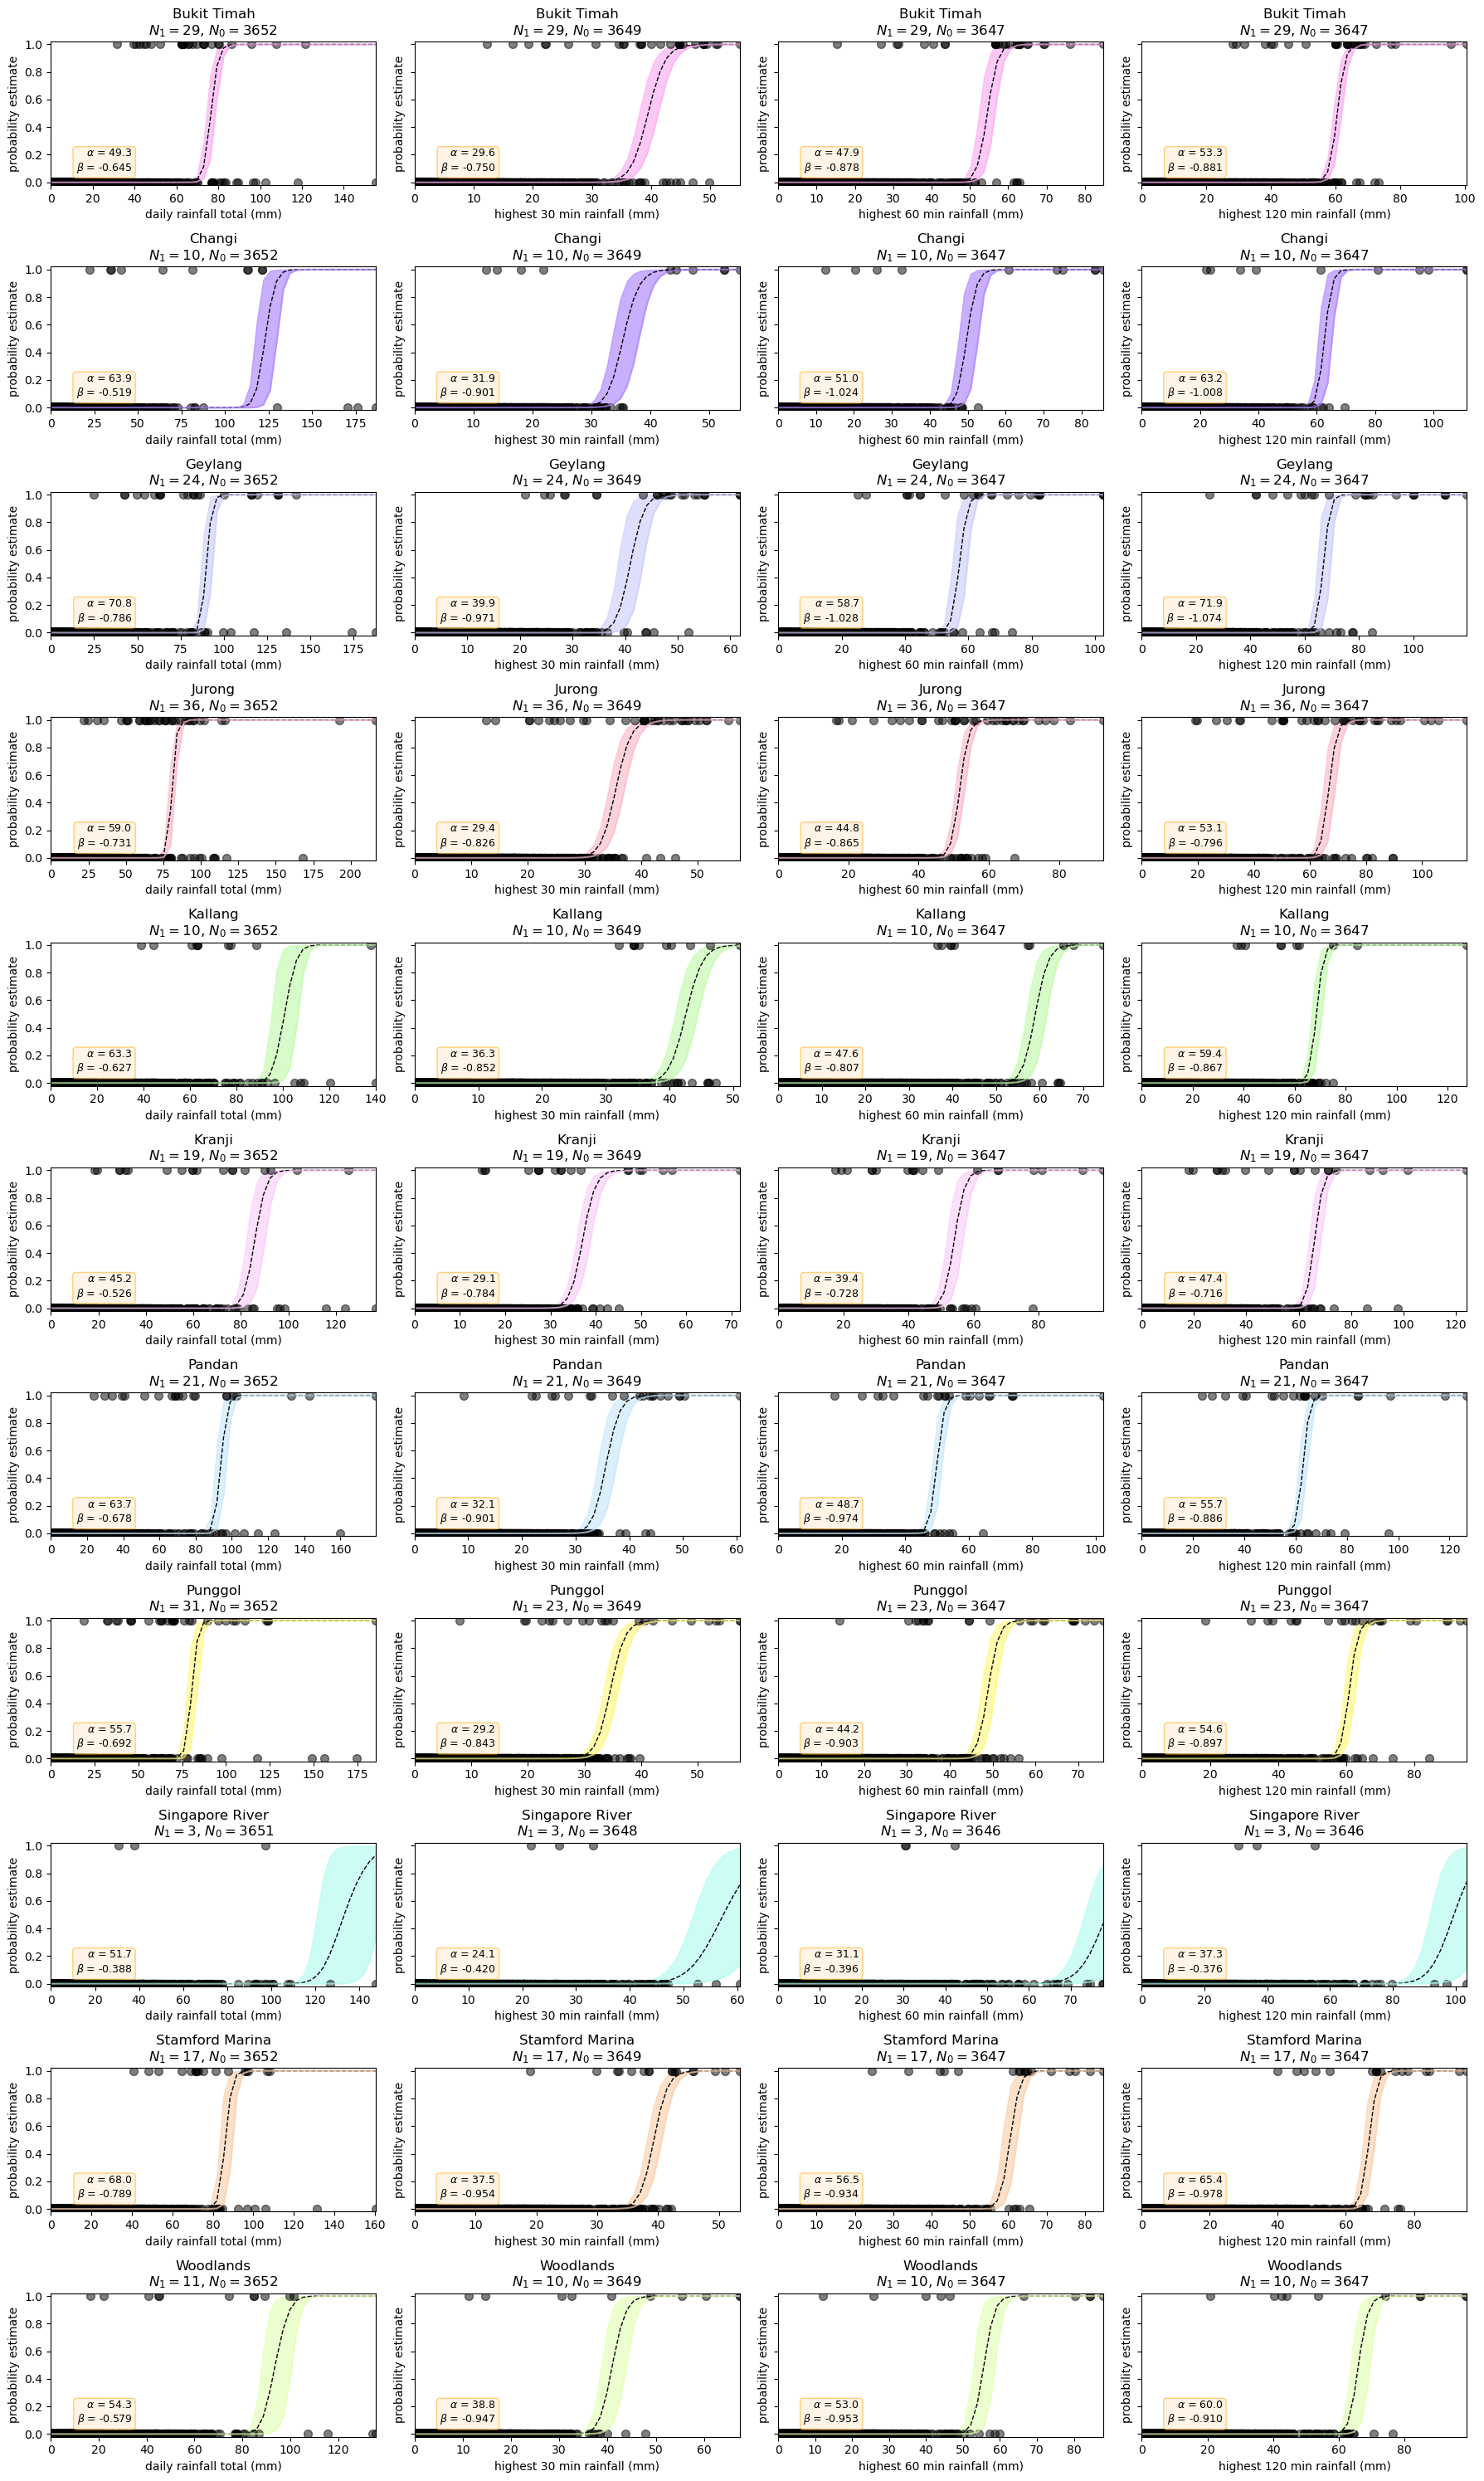

In [ ]:
def plot_posterior_dist_grid(save_dir=None):
    # save_dir = r"Exported_Data"
    # sampled_posterior_fps = [os.path.join(save_dir,fp) for fp in os.listdir(save_dir) if fp.endswith('pkl')]
    colormap = {'Changi':'#b28efe','Punggol':'#fff98b','Woodlands':'#e5ffba','Kallang':'#c7fcb3',
                'Bukit Timah':'#fcb3f4','Stamford Marina':'#fcd3b3','Singapore River':'#b8fcf0',
                'Kranji':'#fcd2fa','Pandan':'#ccebfc','Jurong':'#fcc0cd','Geylang':'#cfd2fc'}
    
    fig, axes = plt.subplots(11,4,figsize=(18,30),sharey=True)
    for row_idx, (drainage_name, rf_dict) in enumerate(flood_occurrences_dict.items()):
        for col_idx, (rf_type, rf) in enumerate(rf_dict.items()):
            y,x = rf # flood occurrence vs ppt
            p_t_fp = os.path.join(os.getcwd(),"Exported_Data",f'ExpectedProb_{drainage_name} ({rf_type}).pkl')
            alpha_fp = os.path.join(os.getcwd(),"Exported_Data",f'alpha_{drainage_name} ({rf_type}).pkl')
            beta_fp = os.path.join(os.getcwd(),"Exported_Data",f'beta_{drainage_name} ({rf_type}).pkl')
            sampled_posterior = load_pickle(p_t_fp)
            alpha = load_pickle(alpha_fp)
            beta = load_pickle(beta_fp)
            ax = axes[row_idx,col_idx]
            plot_fitted_logistic(x,y,sampled_posterior,title=f'{drainage_name} ({rf_type}).pkl',
                                 ax=ax,color = colormap[drainage_name])
            # find number of flood vs non-flood events
            n_flood = y[y>0].shape[0]
            n_non_flood = y.shape[0] - n_flood
            # plot parameters
            bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
            stats = (f'$\\alpha$ = {np.median(alpha):.1f}\n'
             f'$\\beta$ = {np.median(beta):.3f}')
            ax.text(0.25, 0.2, stats, fontsize=9, bbox=bbox,transform=ax.transAxes, horizontalalignment='right')
    
            ax.set_title(f'{drainage_name}\n'+r"$N_1={n_flood}$, $N_0={n_non_flood}$".format(n_flood=n_flood,n_non_flood=n_non_flood))
            ax.set_xlabel(rf_type)

    plt.tight_layout()
    if save_dir is not None and os.path.exists(save_dir):
        plt.savefig(os.path.join(save_dir,f'expected_probability_drainageCatchments.png'), bbox_inches = 'tight')
    plt.show()

plot_posterior_dist_grid(save_dir=os.path.join(os.getcwd(),"Exported_Data"))

## Assess goodness of fit for models
- Calculate accuracy
- class weighted accuracy
- Recall
- Precision
- F1 score
- AUC-ROC
- Precision-Recall AUC

In [36]:
from helper_functions import goodness_of_fit_metrics as flood_metrics

def get_accuracy_metrics(threshold = 0.5,save_dir=None):
    """ outputs a csv file across drainage basins and type of rainfall
    Args:
        threshold (float): threshold above the probability which will classify observation as positive (i.e. flooded)
        save_dir (str): filepath of where to store the csv
    Returns:
        pd.DataFrame: dataframe of the accuracy metrics for each drainage basins and rainfall type
    """
    df_dict = []
    for drainage_name, rf_dict in flood_occurrences_dict.items():
        for rf_type, rf in rf_dict.items():
            y_true,x = rf # flood occurrence vs ppt
            alpha_fp = os.path.join(os.getcwd(),"Exported_Data",f'alpha_{drainage_name} ({rf_type}).pkl')
            beta_fp = os.path.join(os.getcwd(),"Exported_Data",f'beta_{drainage_name} ({rf_type}).pkl')
            alpha = load_pickle(alpha_fp)
            beta = load_pickle(beta_fp)
            beta_mean, alpha_mean = beta.mean(), alpha.mean()
            y_probs = logistic(x, beta_mean, alpha_mean) # outputs probabilities between 0 and 1
            y_pred = y_probs > threshold
            y_pred = y_pred.astype(int) # convert boolean to binary
            # metrics
            assert y_pred.shape[0] == y_true.shape[0], f"both vectors have different length: y_pred: {y_pred.shape}, y_true: {y_true.shape}"
            accuracy = flood_metrics.accuracy(y_true,y_pred)
            precision = flood_metrics.precision(y_true,y_pred)
            recall = flood_metrics.recall(y_true,y_pred)
            f1_score = flood_metrics.f1_score(y_true,y_pred)
            auc_roc = flood_metrics.auc_roc(y_true,y_probs)
            log_loss = flood_metrics.log_loss(y_true,y_probs)

            # find number of flood vs non-flood events
            n_flood = int(y_true[y_true>0].shape[0])
            n_non_flood = int(y_true.shape[0] - n_flood)
            df_dict.append({'drainage_name':drainage_name,'rainfall_type':rf_type,
                            'accuracy':accuracy,'precision':precision,'recall':recall,
                            'f1_score':f1_score, 'auc_roc':auc_roc, 'log_loss':log_loss,
                            'n_flood': n_flood, 'n_non_flood': n_non_flood})
            
    
    df = pd.DataFrame(df_dict)
            
    if save_dir is not None and os.path.exists(save_dir):
        df.to_csv(os.path.join(save_dir,"logistic_curve_goodness_of_fit.csv"),index=False)
    return df

df = get_accuracy_metrics(save_dir=os.path.join(os.getcwd(),"Exported_Data"))
df

,drainage_name,rainfall_type,accuracy,precision,recall,f1_score,auc_roc,log_loss,n_flood,n_non_flood
0,Bukit Timah,daily rainfall total (mm),0.989677,0.304348,0.241379,0.269231,0.988424,0.110378,29,3652
1,Bukit Timah,highest 30 min rainfall (mm),0.994562,0.695652,0.551724,0.615385,0.987687,0.038314,29,3649
2,Bukit Timah,highest 60 min rainfall (mm),0.996464,0.807692,0.724138,0.763636,0.991367,0.047932,29,3647
3,Bukit Timah,highest 120 min rainfall (mm),0.994559,0.695652,0.551724,0.615385,0.992029,0.054854,29,3647
4,Changi,daily rainfall total (mm),0.996177,0.000000,0.000000,0.000000,0.983242,0.079815,10,3652
5,Changi,highest 30 min rainfall (mm),0.998907,1.000000,0.600000,0.750000,0.980132,0.019251,10,3649
6,Changi,highest 60 min rainfall (mm),0.998633,0.857143,0.600000,0.705882,0.980203,0.030195,10,3647
7,Changi,highest 120 min rainfall (mm),0.998086,0.714286,0.500000,0.588235,0.986345,0.036364,10,3647
8,Geylang,daily rainfall total (mm),0.994015,0.562500,0.375000,0.450000,0.991899,0.118147,24,3652
9,Geylang,highest 30 min rainfall (mm),0.997005,0.809524,0.708333,0.755556,0.996300,0.029593,24,3649


# Historical weather data
- max 30 min
- max 60 min
- max 120 min

In [ ]:
imported_data_dir = os.path.join(os.getcwd(),"Exported_Data")
weather_df1 = pd.read_csv(os.path.join(imported_data_dir,"historical_weather.csv"))
historical_weather_percentiles = dict()
for rf_type in weather_df1.columns[5:8].to_list():
    x = weather_df1[rf_type].values
    x = x[~np.isnan(x)]
    p = np.percentile(x, [50, 75, 90, 95, 99]) # CCRS deems extreme ppt at 95th and 99th percentile
    historical_weather_percentiles[rf_type] = p
historical_weather_percentiles

{'highest 30 min rainfall (mm)': array([ 0.2,  4. , 13.8, 21. , 35.6]),
 'highest 60 min rainfall (mm)': array([ 0.2,  4.6, 16.8, 26.6, 47.2]),
 'highest 120 min rainfall (mm)': array([ 0.2,  5.4, 18.8, 30.2, 54.8])}

# Import V3 data

In [ ]:
pr_hr_df = pd.read_csv(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\V3_extracted_data\percentile_pr_1hr.csv")
pr_hr_df # units are kg m-2 s-1, aka mm/s, to conver to mm/hr, multiply by 3600
pr_30mins_df = pr_hr_df.ilo

,percentile,ACCESS-CM2_historical_1995-2014,ACCESS-CM2_ssp126_2040-2059,ACCESS-CM2_ssp126_2080-2099,ACCESS-CM2_ssp245_2040-2059,ACCESS-CM2_ssp245_2080-2099,ACCESS-CM2_ssp585_2040-2059,ACCESS-CM2_ssp585_2080-2099,EC-Earth3_historical_1995-2014,EC-Earth3_ssp126_2040-2059,...,NorESM2-MM_ssp126_2040-2059,NorESM2-MM_ssp126_2080-2099,NorESM2-MM_ssp245_2040-2059,NorESM2-MM_ssp245_2080-2099,NorESM2-MM_ssp585_2040-2059,NorESM2-MM_ssp585_2080-2099,UKESM1-0-LL_ssp126_2040-2059,UKESM1-0-LL_ssp126_2080-2099,UKESM1-0-LL_ssp585_2040-2059,UKESM1-0-LL_ssp585_2080-2099
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96,0.000178,0.000118,0.000125,0.000116,0.000070,0.000087,0.000010,0.000011,0.000003,...,0.000062,0.000073,0.000046,0.000057,0.000079,0.000022,0.000075,0.000041,0.000047,0.000005
97,97,0.000438,0.000336,0.000355,0.000331,0.000245,0.000280,0.000081,0.000075,0.000041,...,0.000218,0.000245,0.000180,0.000209,0.000256,0.000121,0.000235,0.000162,0.000179,0.000051
98,98,0.001028,0.000880,0.000919,0.000873,0.000739,0.000793,0.000390,0.000326,0.000243,...,0.000649,0.000701,0.000574,0.000643,0.000718,0.000469,0.000672,0.000533,0.000573,0.000288
99,99,0.002617,0.002462,0.002562,0.002448,0.002303,0.002318,0.001713,0.001306,0.001143,...,0.001974,0.002052,0.001857,0.002035,0.002080,0.001736,0.002025,0.001786,0.001902,0.001413


In [41]:
pr_hr_df.iloc[:,1:].apply(lambda x: x*1800)

,ACCESS-CM2_historical_1995-2014,ACCESS-CM2_ssp126_2040-2059,ACCESS-CM2_ssp126_2080-2099,ACCESS-CM2_ssp245_2040-2059,ACCESS-CM2_ssp245_2080-2099,ACCESS-CM2_ssp585_2040-2059,ACCESS-CM2_ssp585_2080-2099,EC-Earth3_historical_1995-2014,EC-Earth3_ssp126_2040-2059,EC-Earth3_ssp126_2080-2099,...,NorESM2-MM_ssp126_2040-2059,NorESM2-MM_ssp126_2080-2099,NorESM2-MM_ssp245_2040-2059,NorESM2-MM_ssp245_2080-2099,NorESM2-MM_ssp585_2040-2059,NorESM2-MM_ssp585_2080-2099,UKESM1-0-LL_ssp126_2040-2059,UKESM1-0-LL_ssp126_2080-2099,UKESM1-0-LL_ssp585_2040-2059,UKESM1-0-LL_ssp585_2080-2099
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.320334,0.212646,0.224484,0.208279,0.126590,0.157283,0.018736,0.019028,0.005191,0.019578,...,0.111854,0.131639,0.082587,0.103474,0.142997,0.039663,0.134446,0.074149,0.084017,0.008714
97,0.788240,0.605098,0.638200,0.596441,0.440287,0.504218,0.145495,0.134178,0.074497,0.143281,...,0.392706,0.440428,0.324284,0.377060,0.460352,0.218648,0.423841,0.292125,0.321881,0.092281
98,1.849613,1.583923,1.654547,1.570613,1.329637,1.427443,0.702831,0.586855,0.436979,0.635278,...,1.167756,1.261412,1.033425,1.157737,1.292424,0.844675,1.209094,0.959931,1.032240,0.518811
99,4.710731,4.432477,4.612083,4.407132,4.144869,4.171762,3.083713,2.349993,2.058156,2.524531,...,3.552590,3.693611,3.342282,3.662759,3.743438,3.124068,3.644863,3.214631,3.423688,2.543263
